In [75]:
import warnings  
warnings.filterwarnings('ignore')

# basics
import pandas as pd
import numpy as np
import math

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import itertools
from matplotlib.lines import Line2D

# regression
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.compat import lzip

# other prediction methods
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# evalutiation
import statsmodels.tools.eval_measures as smem
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV

In [87]:
cRange = ['#475468', '#e7e6e6', '#4b73be', '#df8244', '#a5a5a5', '#f7c143',
          '#20406a', '#deeef8', '#2d6fc0', '#409cd4', '#5ccdd7', '#5ecb9e',
          '#a53218', '#c59933', '#f08a40', '#aa4f30', '#f7bf5d', '#d85733',
          '#728083', '#8babb4', '#7196ad', '#607397', '#8585c2', '#a687c1']
colors = ['#475468', '#a687c1', '#4b73be', 
          '#df8244', '#a5a5a5', '#f7c143'] 
cmapOffice = mpl.colors.ListedColormap([cRange[i] for i in range(0, 5)])
cmapBlue = mpl.colors.ListedColormap([cRange[i] for i in range(6, 11)])
cmapRed = mpl.colors.ListedColormap([cRange[i] for i in range(12, 17)])
cmapViolett = mpl.colors.ListedColormap([cRange[i] for i in range(18, 23)])

In [156]:
df = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
df.index = pd.to_datetime(df.index)


# add hourly moving avg total
df["hourly_moving_avg_2"] = df["hourly_moving_avg_2_solar"] + df["hourly_moving_avg_2_wind"]
df["hourly_moving_avg"] = df["hourly_moving_avg_solar"] + df["hourly_moving_avg_solar"]
df["hourly_moving_avg_7"] = df["hourly_moving_avg_7_solar"] + df["hourly_moving_avg_7_wind"]

# Shift moving averages because values are not known at time of prediction
dropCols = list()
for c in df.columns:
    if "wind" in c or "solar" in c:
        dropCols.append(c)
    elif "avg" in c or "max" in c:
        dropCols.append(c)
        df[c+"_shifted"] = df[c].shift(24)
        df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00", c+"_shifted"] = 0 # to avoid NaN value

data = df[["price_diff", "hour", "season", "month", "weekday", "total_generation_forecast", "forecast_error", "day_ahead_price", "intraday_price"]]

## Feature selection

Index(['hour', 'total_generation_forecast', 'forecast_error', 'season',
       'month', 'weekday', 'mov_avg_30_forecast_error_shifted',
       'mov_avg_10_forecast_error_shifted', 'mov_avg_1_forecast_error_shifted',
       'mov_avg_1_day_ahead_shifted', 'mov_avg_1_intraday_shifted',
       'hourly_moving_avg_2_shifted', 'hourly_moving_avg_shifted',
       'hourly_moving_avg_7_shifted'],
      dtype='object')
training set class distribution:
1    0.502432
0    0.497568
Name: price_diff, dtype: float64
holdout set class distribution:
1    0.504788
0    0.495212
Name: price_diff, dtype: float64
=> same class frequency in holdout and training set => accuracy is valid metric


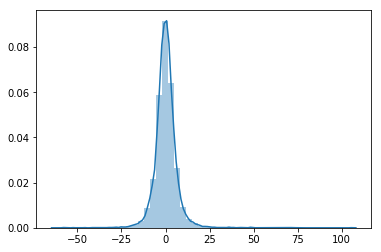

In [172]:
X_pd = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
            # not known:
                "day_ahead_price",
                "intraday_price",
                "price_diff",
                "total_generation_actual"
                 ], axis=1)
X_pd = X_pd.reset_index()
X_pd = X_pd.drop("datetime", axis=1)
print(X_pd.columns)

y_pd_val = pd.DataFrame(df["price_diff"], index=df.index)

# find distribution of price diff values to build classes
sns.distplot(y_pd_val)

def convertToClasses(y, classNum):
    values = range(0, classNum)
    if classNum==4:
        y2 = y.applymap(lambda y: values[[(y<-3), ((-3<=y) & (y<0)), ((0<=y) & (y<3)), y>=3].index(True)])
    else:
        y2 = y.applymap(lambda y: values[[y < 0, y >= 0].index(True)])
    return y2


y_pd = convertToClasses(y_pd_val, 2)

# Create a holdout set for later testing of the methods. Try to predict class positive/negative for positive or negative price_diff
X, X_holdout, y, y_holdout = train_test_split(X_pd, y_pd);

y_holdout_val = y_pd_val.loc[y_holdout.index.values]
print("training set class distribution:")
print(y.price_diff.value_counts()/len(y))
print("holdout set class distribution:")
print(y_holdout.price_diff.value_counts()/len(y_holdout))
print("=> same class frequency in holdout and training set => accuracy is valid metric")

### Evaluation metrics

In [54]:
# Find costs for misclassification
print("Mean price differences for the different heights of price differences")
print(df[df.price_diff<-3].price_diff.mean())
print(df[(df.price_diff>-3) & (df.price_diff<=0)].price_diff.mean())
print(df[(df.price_diff>0) & (df.price_diff<3)].price_diff.mean())
print(df[df.price_diff>=3].price_diff.mean())

Mean price differences for the different heights of price differences
-6.944230222643307
-1.437647320435845
1.4159768064228389
7.505088935088937


In [119]:
numberOfRuns = 5 # 5 times cross-validaton

def custom_loss_func(y_true, y_pred):
    y2 = convertToClasses(y_true,4)
    y2 = np.concatenate((y2["price_diff"].values.reshape(len(y2), 1), y_pred.reshape(len(y_pred), 1)), axis=1)
    # y2 = y_true | y_pred
    criteria = [((y2[:,1]==0) & (y2[:,0]==2)) | ((y2[:,1] == 1) & (y2[:,0] == 1)), 
                ((y2[:,1]==0) & (y2[:,0]==3)) | ((y2[:,1] == 1) & (y2[:,0] == 0))]
    values = [1.4, 7]
    cost = np.select(criteria, values, 0)
    return cost.sum()

# Dict containing the scorers to be used for classification
scoring = {'accuracy': 'accuracy',
            'precision': 'precision',
              'recall':'recall'
          }

# Function to convert the list of dicts to a DataFrame and then print it for classification scores
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=[list(range(numberOfRuns))*len(param_range), list(param_range)*numberOfRuns]).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["accuracy",
                       "precision", # fraction of actual price increases in predicted price increases
                       "recall"]    # fraction of price increases that are identified as such
    scores_df = scores_df.groupby(level=1).mean()
    return scores_df
    
# function to build a cross-validated confusion matrix
def makeConfusionMatrix(model):
    unifiedCM = np.zeros([2,2])
    kf = KFold(n_splits=3)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        unifiedCM = unifiedCM+cm

    return (unifiedCM / unifiedCM.sum()).round(2)


## Try different prediction methods

In [132]:
def plotGridResults(results, paramName):
    plt.figure(figsize=(5, 5))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

    plt.xlabel(paramName)
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(0, 402)
    ax.set_ylim(0.5, 0.9)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+paramName].data, dtype=float)

    for scorer, color in zip(sorted(scoring), colors):
        print(scorer)
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    #plt.legend(loc="best")
    plt.grid('off')
    plt.show()

In [110]:
grid = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), 
                    param_grid={'C': [0.001,0.01,0.1,1,10,100]}, scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)

{'C': 1}


In [113]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                    param_grid={'max_depth': range(1, 30), 
                                'min_samples_split': range(2, 5), 
                                'min_samples_leaf': range(1,5)}, 
                    scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)

{'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
plotGridResults(results, 'max_depth')

In [59]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                    param_grid={'max_depth': range(1, 30), 
                                'n_estimators': [20, 50],
                                'min_samples_split': range(2, 4), 
                                'min_samples_leaf': range(1,5)}, 
                    scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)


{'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


accuracy
precision
recall


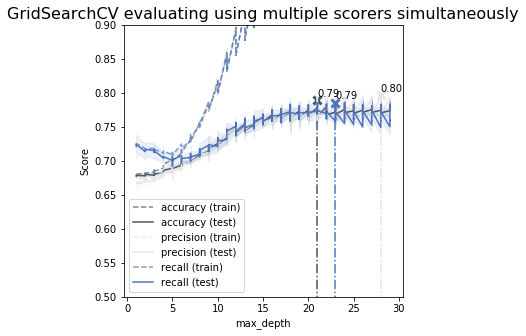

In [62]:
plotGridResults(results, 'max_depth')

In [120]:
# Method: Naive Bayes
scores_list = []
param_range = range(2)
for j in range(numberOfRuns):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for i in param_range:
        nb = GaussianNB()
        scores_list.append(cross_validate(nb, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,accuracy,precision,recall
0,0.668856,0.656845,0.718091
1,0.668856,0.656845,0.718091


## Evaluation

Final evaluation of classifiers with holdout set

In [21]:
# plot confusion matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    y_true = convertToClasses(y_true, 4)
    y = np.concatenate((y_true["price_diff"].values.reshape(len(y_true), 1), y_pred.reshape(len(y_pred), 1)), axis=1)

    # create 4x2 modified confusion nmatrix
    cm = np.zeros([4,2])
    for i in range(4):
        for j in range(2):
            cm[i,j] = ((y[:,0]==i) & (y[:,1]==j)).sum()

    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(2)
    y_tick_marks = np.arange(4)
    plt.xticks(x_tick_marks, ["Intraday", "Day ahead"], rotation=45)
    plt.yticks(y_tick_marks, ["ID cheaper (++)", "ID cheaper (+)", "DA cheaper (+)", "DA cheaper (++)"])

    fmt = '.2f' #if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True choice')
    plt.xlabel('Market choice')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return cm

No handles with labels found to put in legend.


Decision Tree
Normalized confusion matrix


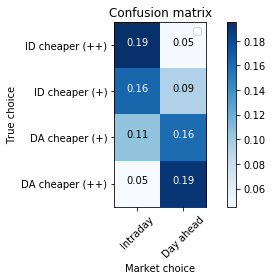

Sum of diagonal: [0.35522116]


No handles with labels found to put in legend.


Random Forest
Normalized confusion matrix


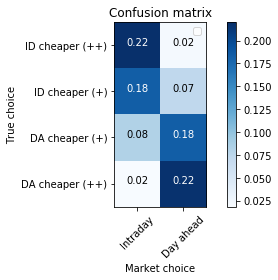

Sum of diagonal: [0.40378477]


No handles with labels found to put in legend.


Logistic Regression
Normalized confusion matrix


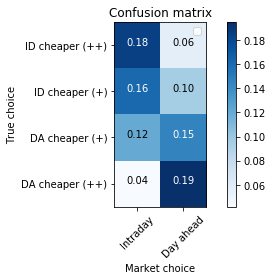

No handles with labels found to put in legend.


Sum of diagonal: [0.33036936]
Naive Bayes
Normalized confusion matrix


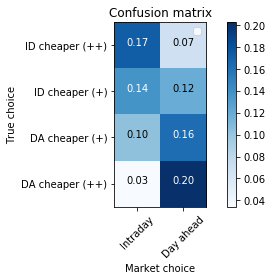

Sum of diagonal: [0.33470132]


,Accuracy,Precision,Recall,Cost
Random Forest,0.806202,0.811034,0.800726,2170
Decision Tree,0.709986,0.71621,0.699955,4032
Logistic Regression,0.685819,0.691061,0.677258,4342.8
Naive Bayes,0.674419,0.659926,0.725828,4536
DA,0.50228,0.50228,1,8981
Random,0.501368,0.50377,0.485247,8841
ID,0.49772,0,0,8897


In [134]:
# get test metrics for holdout set

results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Cost"])
estimators = [DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=2),
              RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1),
              linear_model.LogisticRegression(C=0.01),
              GaussianNB()]
estimatorNames = ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "Day Ahead", "Intraday", "Random"]

def evalHoldout(est, estName):
    model = est.fit(X, y)
    y_pred = model.predict(X_holdout)
    results.loc[estName, "Accuracy"] = accuracy_score(y_holdout, y_pred)
    results.loc[estName, "Precision"] = precision_score(y_holdout, y_pred)
    results.loc[estName, "Recall"] = recall_score(y_holdout, y_pred)
    results.loc[estName, "Cost"] = custom_loss_func(y_holdout_val, y_pred)
    print(estName)
    cm = plot_confusion_matrix(y_holdout_val, y_pred, normalize=True)
    print("Sum of diagonal:", cm[0:1,0]+cm[2:3,1])

for est, estName in zip(estimators, estimatorNames):
    evalHoldout(est, estName)

# Always day ahead
y_pred = np.ones(len(y_holdout))
results.loc["DA", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["DA", "Precision"] = precision_score(y_holdout, y_pred)
results.loc["DA", "Recall"] = recall_score(y_holdout, y_pred)
results.loc["DA", "Cost"] = custom_loss_func(y_holdout_val, y_pred)

# Always intraday
y_pred = np.zeros(len(y_holdout))
results.loc["ID", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["ID", "Precision"] = precision_score(y_holdout, y_pred)
results.loc["ID", "Recall"] = recall_score(y_holdout, y_pred)
results.loc["ID", "Cost"] = custom_loss_func(y_holdout_val, y_pred)

# Random
y_pred = np.random.randint(2, size=len(y_holdout))
results.loc["Random", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["Random", "Precision"] = precision_score(y_holdout, y_pred)
results.loc["Random", "Recall"] = recall_score(y_holdout, y_pred)
results.loc["Random", "Cost"] = custom_loss_func(y_holdout_val, y_pred)

display(results.sort_values("Accuracy", ascending=False))

In [161]:
# Test if RFC with two features is similarly accurate
RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
RFC.fit(X[["forecast_error", "total_generation_forecast"]].values, y)
y_pred = RFC.predict(X_holdout[["forecast_error", "total_generation_forecast"]])
accuracy_score(y_holdout, y_pred)

0.6383948928408573

## Combined prediction model

In [154]:
# prepare data for solar forecast error prediction
y_sfe = df.solar_forecast_error

dropCols = list()
for c in df.columns:
    if ("wind" in c) | ("total" in c):
        dropCols.append(c)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        dropCols.append(c)

X_sfe = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
             # What we want to predict
             "solar_forecast_error",
             "forecast_error",
    
             # Not known then
             "solar_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff",
             "solar_24h_max"
            ], axis=1)
X_sfe = X_sfe.reset_index()
X_sfe = X_sfe.drop("datetime", axis=1)
  
# prepare data for wind forecast error prediction
y_wfe = df.wind_forecast_error

dropCols = list()
for c in df.columns:
    if ("solar" in c) | ("total" in c):
        dropCols.append(c)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        dropCols.append(c)

X_wfe = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
             # What we want to predict
             "wind_forecast_error",
             "forecast_error",
    
             # Not known then
             "wind_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff",
             
             "wind_24h_max"
            ], axis=1)
X_wfe = X_wfe.reset_index()
X_wfe = X_wfe.drop("datetime", axis=1)

# use predicted forecast error for price diff prediction
def predictSolarForecastError(X_train, X_test):

    myX_train = X_sfe.iloc[X_train.index.values]
    myX_test = X_sfe.iloc[X_test.index.values]
    myy_train = y_sfe.iloc[X_train.index.values]
    myy_test = y_sfe.iloc[X_test.index.values]

    RFR = RandomForestRegressor(max_depth=25, 
                                n_estimators = 100, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                max_features='auto', 
                                n_jobs=-1)
    RFR.fit(myX_train, myy_train)
    y_pred = RFR.predict(myX_test)
    return y_pred

def predictWindForecastError(X_train, X_test):
        
    myX_train = X_wfe.iloc[X_train.index.values]
    myX_test = X_wfe.iloc[X_test.index.values]
    myy_train = y_wfe.iloc[X_train.index.values]
    myy_test = y_wfe.iloc[X_test.index.values]

    RFR = RandomForestRegressor(max_depth=35, 
                                n_estimators = 100, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                max_features='auto',
                                n_jobs=-1)
    RFR.fit(myX_train, myy_train)
    y_pred = RFR.predict(myX_test)
    return y_pred

Weights of features for random forest


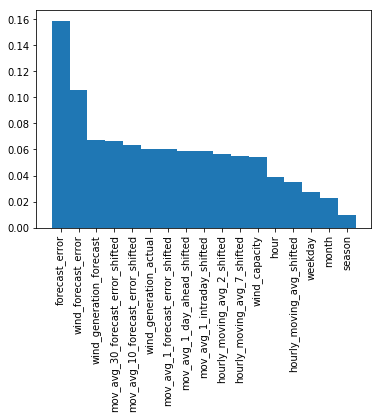

[(0.1589, 'forecast_error'),
 (0.1053, 'wind_forecast_error'),
 (0.0669, 'wind_generation_forecast'),
 (0.0667, 'mov_avg_30_forecast_error_shifted'),
 (0.0631, 'mov_avg_10_forecast_error_shifted'),
 (0.0605, 'wind_generation_actual'),
 (0.0604, 'mov_avg_1_forecast_error_shifted'),
 (0.0591, 'mov_avg_1_day_ahead_shifted')]

In [155]:
X_train, X_test, y_train2, y_test2 = train_test_split(X_pd, y_pd_val)
y_train = convertToClasses(y_train2, 2)
y_test = convertToClasses(y_test2, 2)
y_pred = predictSolarForecastError(X_train, X_test) + predictWindForecastError(X_train, X_test)
X_test["forecast_error"] = y_pred

RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

print("Weights of features for random forest")
# See how important the features of the data frame are for the prediction with Random Forests
features = sorted(zip(map(lambda x: round(x, 4), RFC.feature_importances_), X.columns), reverse=True)
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features[0:8]

No handles with labels found to put in legend.


Accuracy: 0.8011855905152758
Precision: 0.8006386861313869
Recall: 0.8013698630136986
Normalized confusion matrix


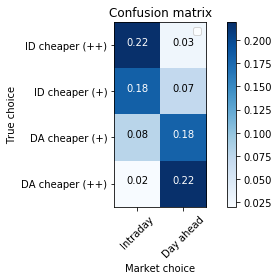

In [137]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
plt.figure()
plot_confusion_matrix(y_test2, y_pred, normalize=True)
plt.show();

## Simulation of strategies

In [138]:
def getCostsForDayAhead(data):
    return data.day_ahead_price.sum(axis=0)

def getCostsForIntraday(data):
    return data.intraday_price.sum(axis=0)

def getCostsForRandom(data):
    permutation = np.random.permutation(len(data))
    ind = permutation[:int(len(permutation)*0.5)]
    indIntraday = permutation[int(len(permutation)*0.5):]
    dayAhead = data.iloc[ind,:]
    intraday = data.iloc[indIntraday,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

# choose a fraction based on cond. probability of the neg. forecast errors randomly 
def getCostsForCondProb(X_train, y_train, X_test, data_test):
    condProb = 0.66  # from other notebook
    pred = data["forecast_error"]
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_forecast_error"]
    pred.index = data.index
    merged = data_test.join(pred)
    intradayIndices = merged.loc[merged.pred_forecast_error<0,:].sample(frac=condProb).index.values
    dayAheadIndices = list(set(merged.index.values) - set(intradayIndices))
    intraday = merged.loc[intradayIndices]
    dayAhead = merged.loc[dayAheadIndices]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForRandomForest(X_train, y_train, X_test, data_test):
    RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
    RFC.fit(X_train, y_train)
    pred = RFC.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff==0,:]
    dayAhead = merged.loc[merged.pred_price_diff==1,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForDecisionTree(X_train, y_train, X_test, data_test):
    DTC = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=2)
    DTC.fit(X_train, y_train)
    pred = DTC.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff==0,:]
    dayAhead = merged.loc[merged.pred_price_diff==1,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

### Simulation of decision strategies

In [142]:
methods = ["DayAhead", "Intraday", "Random", "CondProb", "DecisionTree", "RandomForest"]
methodResults = pd.DataFrame(columns=methods)
for n in range(100):
    X_train, X_test, y_train, y_test  = train_test_split(X_pd, y_pd)
    X_test["forecast_error"] = predictSolarForecastError(X_train, X_test) + predictWindForecastError(X_train, X_test)
    data_test = data.iloc[X_test.index.values]
    res = []
    res.append(getCostsForDayAhead(data_test))
    res.append(getCostsForIntraday(data_test))
    res.append(getCostsForRandom(data_test))
    res.append(getCostsForCondProb(data_test))
    res.append(getCostsForDecisionTree(X_train, y_train, X_test, data_test))
    res.append(getCostsForRandomForest(X_train, y_train, X_test, data_test))
    methodResults.loc[n] = res
#print(methodResults)

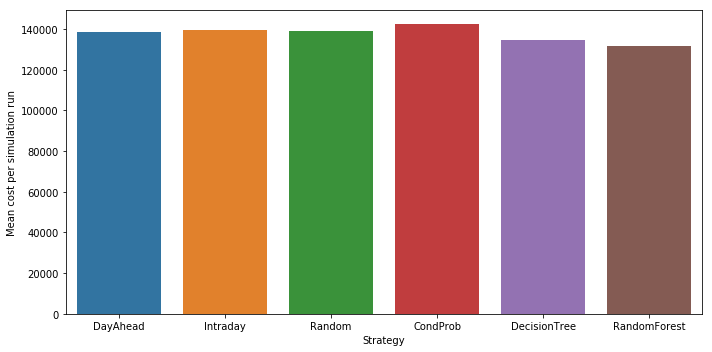

In [143]:
fig = plt.figure(figsize=(10,5))
sns.barplot(methodResults.columns.values, methodResults.mean())
plt.ylabel("Mean cost per simulation run")
plt.xlabel("Strategy")
plt.tight_layout()
plt.show();

    DayAhead   Intraday     Random   CondProb  DecisionTree  RandomForest
0  137977.62  138964.76  138582.85  141540.73     133934.88     131015.66
1  140450.26  141344.60  140925.95  144175.57     135993.94     133608.19
2  138263.48  138950.51  139186.53  141936.07     133881.28     131551.91
3  139830.26  140146.52  139842.74  143173.07     135087.56     132742.02


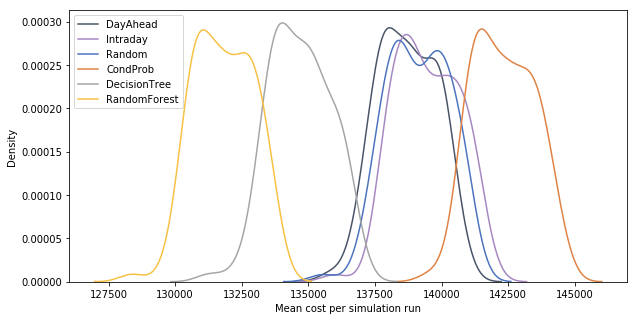

In [146]:
methodResults.to_csv("SimulationResults.csv", sep=";", decimal=",")
fig = plt.figure(figsize=(10,5))
print(methodResults.head(4))
for m in range(len(methods)):
    sns.kdeplot(methodResults.loc[:,methods[m]], color=colors[m], label=methods[m])
plt.legend()
plt.xlabel("Mean cost per simulation run")
plt.ylabel("Density",)
plt.show();

In [147]:
print("F-Test to determine if methods produce costs of same distribution")
stat, p = f_oneway(methodResults["DayAhead"], methodResults["Intraday"], methodResults["Random"], methodResults["DecisionTree"], methodResults["CondProb"], methodResults["RandomForest"])
print(stat)
print(p)
print("t-Test for Significance of difference between Day-ahead and regression")
print(stats.ttest_ind(methodResults["DayAhead"], methodResults["RandomForest"], equal_var=False))
print("Difference is significant")

F-Test to determine if methods produce costs of same distribution
1120.4599404200076
1.1859421214081495e-299
t-Test for Significance of difference between Day-ahead and regression
Ttest_indResult(statistic=44.466903221024104, pvalue=5.5122677530293064e-105)
Difference is significant
